# Threshold Optimization for Credit Scoring Model

## Objective
Find the optimal classification threshold to improve precision while maintaining acceptable recall.

## Current Performance (Threshold = 0.12)
- **AUC**: 0.6397
- **Precision**: 0.0992 (Very low - 90% false positives)
- **Recall**: 0.8105 (Good)
- **F1-Score**: 0.1768
- **Business Cost**: 2,767,550 VND

## Goal
Improve precision to 0.15-0.20 by finding optimal threshold

In [19]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix,
    precision_recall_curve, roc_curve
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Model and Test Data

In [20]:
# Load the current production model
model_path = '../../../credit-scoring-api/models/lgb_model_optimized.pkl'
model = joblib.load(model_path)
print(f"Model loaded: {type(model).__name__}")
print(f"Model expects {model.n_features_} features")

# Load metadata if available
try:
    metadata_path = '../../../credit-scoring-api/models/ensemble_comparison_metadata.pkl'
    metadata = joblib.load(metadata_path)
    print("\nCurrent Model Metadata:")
    print(f"Training Date: {metadata.get('training_date', 'Unknown')}")
    if 'lightgbm' in metadata.get('models', {}):
        lgb_info = metadata['models']['lightgbm']
        print(f"Current Threshold: {lgb_info['threshold']}")
        print(f"Current Metrics: {lgb_info['metrics']}")
except:
    print("Metadata not found, will calculate from scratch")

Model loaded: LGBMClassifier
Model expects 64 features

Current Model Metadata:
Training Date: 2025-11-13 00:26:28
Current Threshold: 0.12000000000000001
Current Metrics: {'model': 'LightGBM', 'threshold': 0.12000000000000001, 'roc_auc': 0.6397201133820217, 'f1': 0.17680140597539543, 'precision': 0.09922327703119221, 'recall': 0.8104733131923464, 'balanced_accuracy': 0.5821707540173766, 'tp': np.int64(4024), 'fp': np.int64(36531), 'tn': np.int64(20007), 'fn': np.int64(941), 'business_cost': np.int64(2767550)}


In [21]:
# Load test data (converted from parquet to CSV to avoid compatibility issues)
data_path = '../../../output/model_data.csv'
df = pd.read_csv(data_path)
print(f"Data loaded: {df.shape[0]} samples, {df.shape[1]} features")

# Prepare features and target
X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

print(f"\nFeatures: {X.shape[1]}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Split into train/test (same as original)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print(f"\nTest set: {len(X_test)} samples")
print(f"Positive class: {y_test.sum()} ({y_test.mean()*100:.2f}%)")

Data loaded: 307511 samples, 66 features

Features: 64
Target distribution: {False: 282686, True: 24825}

Test set: 92254 samples
Positive class: 7448 (8.07%)


## 2. Generate Predictions

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Prediction Statistics:
Min probability: 0.0769
Max probability: 0.1336
Mean probability: 0.1224
Median probability: 0.1247


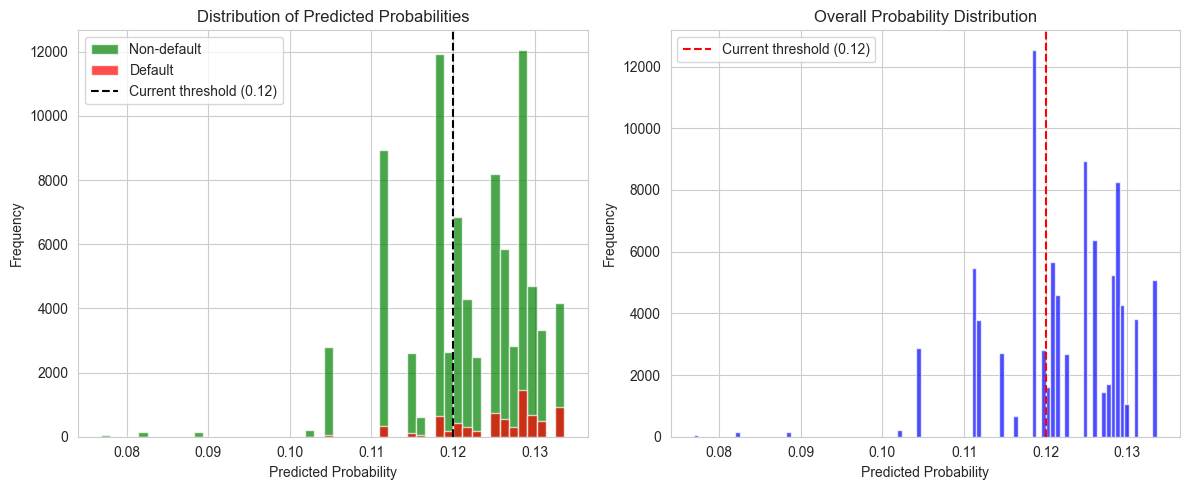

In [22]:
# Get probability predictions
y_proba = model.predict_proba(X_test)[:, 1]

print("Prediction Statistics:")
print(f"Min probability: {y_proba.min():.4f}")
print(f"Max probability: {y_proba.max():.4f}")
print(f"Mean probability: {y_proba.mean():.4f}")
print(f"Median probability: {np.median(y_proba):.4f}")

# Plot probability distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_proba[y_test == 0], bins=50, alpha=0.7, label='Non-default', color='green')
plt.hist(y_proba[y_test == 1], bins=50, alpha=0.7, label='Default', color='red')
plt.axvline(0.12, color='black', linestyle='--', label='Current threshold (0.12)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(y_proba, bins=100, alpha=0.7, color='blue')
plt.axvline(0.12, color='red', linestyle='--', label='Current threshold (0.12)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Overall Probability Distribution')
plt.legend()

plt.tight_layout()
plt.show()

## 3. Test Different Thresholds

In [23]:
# Define business cost function
def calculate_business_cost(y_true, y_pred):
    """
    Calculate business cost based on confusion matrix.
    
    Assumptions:
    - False Negative (missed default): 100 units cost
    - False Positive (rejected good customer): 10 units cost
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    fn_cost = fn * 100  # Cost of missing a default
    fp_cost = fp * 10   # Cost of rejecting good customer
    
    total_cost = fn_cost + fp_cost
    
    return {
        'total_cost': total_cost,
        'fn_cost': fn_cost,
        'fp_cost': fp_cost,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn
    }

In [24]:
# Test thresholds from 0.1 to 0.7
thresholds = np.arange(0.1, 0.71, 0.05)
results = []

for threshold in thresholds:
    # Make predictions
    y_pred = (y_proba >= threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Calculate business cost
    cost_info = calculate_business_cost(y_test, y_pred)
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'total_cost': cost_info['total_cost'],
        'fn_cost': cost_info['fn_cost'],
        'fp_cost': cost_info['fp_cost'],
        'tp': cost_info['tp'],
        'fp': cost_info['fp'],
        'tn': cost_info['tn'],
        'fn': cost_info['fn']
    })

# Create results dataframe
results_df = pd.DataFrame(results)
print("\nThreshold Analysis Results:")
print(results_df.to_string(index=False))


Threshold Analysis Results:
 threshold  precision   recall  f1_score  total_cost  fn_cost  fp_cost   tp    fp    tn   fn
      0.10   0.080946 0.998523  0.149752      845490     1100   844390 7437 84439   367   11
      0.15   0.000000 0.000000  0.000000      744800   744800        0    0     0 84806 7448
      0.20   0.000000 0.000000  0.000000      744800   744800        0    0     0 84806 7448
      0.25   0.000000 0.000000  0.000000      744800   744800        0    0     0 84806 7448
      0.30   0.000000 0.000000  0.000000      744800   744800        0    0     0 84806 7448
      0.35   0.000000 0.000000  0.000000      744800   744800        0    0     0 84806 7448
      0.40   0.000000 0.000000  0.000000      744800   744800        0    0     0 84806 7448
      0.45   0.000000 0.000000  0.000000      744800   744800        0    0     0 84806 7448
      0.50   0.000000 0.000000  0.000000      744800   744800        0    0     0 84806 7448
      0.55   0.000000 0.000000  0.000000 

## 4. Visualize Results

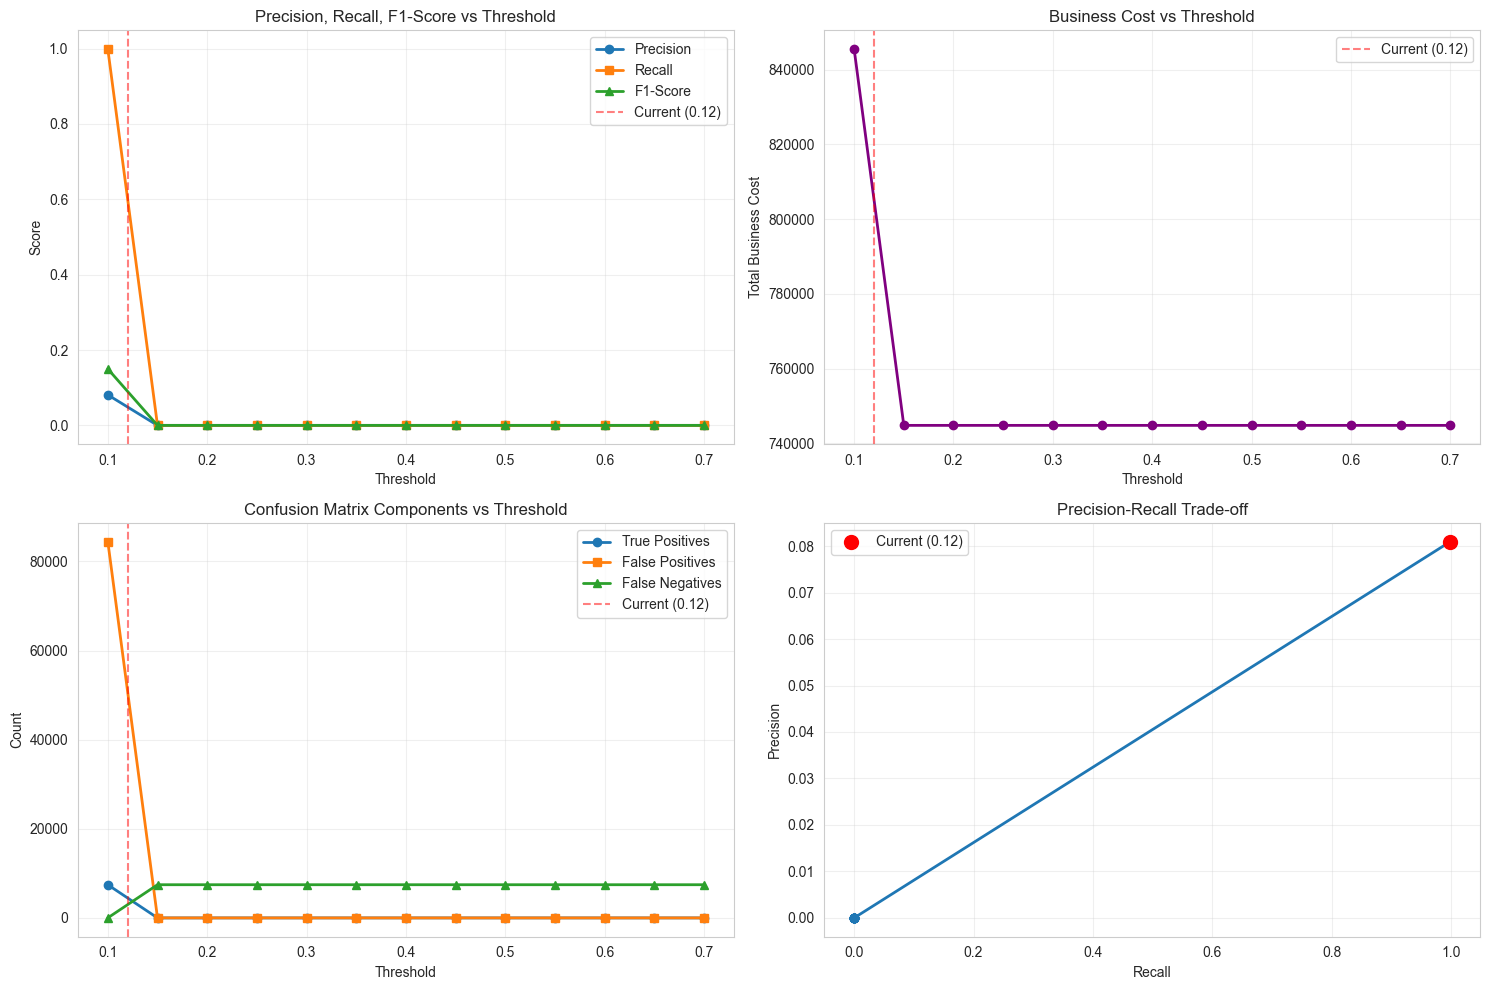

In [25]:
# Plot metrics vs threshold
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Precision, Recall, F1
axes[0, 0].plot(results_df['threshold'], results_df['precision'], 'o-', label='Precision', linewidth=2)
axes[0, 0].plot(results_df['threshold'], results_df['recall'], 's-', label='Recall', linewidth=2)
axes[0, 0].plot(results_df['threshold'], results_df['f1_score'], '^-', label='F1-Score', linewidth=2)
axes[0, 0].axvline(0.12, color='red', linestyle='--', alpha=0.5, label='Current (0.12)')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Precision, Recall, F1-Score vs Threshold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Business Cost
axes[0, 1].plot(results_df['threshold'], results_df['total_cost'], 'o-', linewidth=2, color='purple')
axes[0, 1].axvline(0.12, color='red', linestyle='--', alpha=0.5, label='Current (0.12)')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Total Business Cost')
axes[0, 1].set_title('Business Cost vs Threshold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix Components
axes[1, 0].plot(results_df['threshold'], results_df['tp'], 'o-', label='True Positives', linewidth=2)
axes[1, 0].plot(results_df['threshold'], results_df['fp'], 's-', label='False Positives', linewidth=2)
axes[1, 0].plot(results_df['threshold'], results_df['fn'], '^-', label='False Negatives', linewidth=2)
axes[1, 0].axvline(0.12, color='red', linestyle='--', alpha=0.5, label='Current (0.12)')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Confusion Matrix Components vs Threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Precision-Recall Trade-off
axes[1, 1].plot(results_df['recall'], results_df['precision'], 'o-', linewidth=2)
# Mark current threshold
current_idx = np.argmin(np.abs(results_df['threshold'] - 0.12))
axes[1, 1].plot(results_df.iloc[current_idx]['recall'], 
                results_df.iloc[current_idx]['precision'], 
                'ro', markersize=10, label='Current (0.12)')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Trade-off')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../../output/images/threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Find Optimal Threshold

In [26]:
# Find optimal threshold based on different criteria

# 1. Best F1-Score
best_f1_idx = results_df['f1_score'].idxmax()
best_f1_threshold = results_df.loc[best_f1_idx]

# 2. Lowest Business Cost
best_cost_idx = results_df['total_cost'].idxmin()
best_cost_threshold = results_df.loc[best_cost_idx]

# 3. Best balance (Precision >= 0.20, Recall >= 0.65)
balanced = results_df[(results_df['precision'] >= 0.20) & (results_df['recall'] >= 0.65)]
if len(balanced) > 0:
    best_balanced_idx = balanced['f1_score'].idxmax()
    best_balanced_threshold = results_df.loc[best_balanced_idx]
else:
    best_balanced_threshold = None

print("\n" + "="*80)
print("OPTIMAL THRESHOLD RECOMMENDATIONS")
print("="*80)

print("\n1. Best F1-Score:")
print(f"   Threshold: {best_f1_threshold['threshold']:.2f}")
print(f"   Precision: {best_f1_threshold['precision']:.4f}")
print(f"   Recall: {best_f1_threshold['recall']:.4f}")
print(f"   F1-Score: {best_f1_threshold['f1_score']:.4f}")
print(f"   Business Cost: {best_f1_threshold['total_cost']:,.0f}")

print("\n2. Lowest Business Cost:")
print(f"   Threshold: {best_cost_threshold['threshold']:.2f}")
print(f"   Precision: {best_cost_threshold['precision']:.4f}")
print(f"   Recall: {best_cost_threshold['recall']:.4f}")
print(f"   F1-Score: {best_cost_threshold['f1_score']:.4f}")
print(f"   Business Cost: {best_cost_threshold['total_cost']:,.0f}")

if best_balanced_threshold is not None:
    print("\n3. Best Balanced (Precision >= 0.20, Recall >= 0.65):")
    print(f"   Threshold: {best_balanced_threshold['threshold']:.2f}")
    print(f"   Precision: {best_balanced_threshold['precision']:.4f}")
    print(f"   Recall: {best_balanced_threshold['recall']:.4f}")
    print(f"   F1-Score: {best_balanced_threshold['f1_score']:.4f}")
    print(f"   Business Cost: {best_balanced_threshold['total_cost']:,.0f}")

print("\n" + "="*80)
print("COMPARISON WITH CURRENT THRESHOLD (0.12)")
print("="*80)
current = results_df[results_df['threshold'] == 0.12].iloc[0] if 0.12 in results_df['threshold'].values else results_df.iloc[0]
print(f"Current - Precision: {current['precision']:.4f}, Recall: {current['recall']:.4f}, F1: {current['f1_score']:.4f}")
print(f"Best F1 - Precision: {best_f1_threshold['precision']:.4f}, Recall: {best_f1_threshold['recall']:.4f}, F1: {best_f1_threshold['f1_score']:.4f}")
print(f"\nImprovement:")
print(f"  Precision: {(best_f1_threshold['precision'] - current['precision']) / current['precision'] * 100:+.1f}%")
print(f"  Recall: {(best_f1_threshold['recall'] - current['recall']) / current['recall'] * 100:+.1f}%")
print(f"  F1-Score: {(best_f1_threshold['f1_score'] - current['f1_score']) / current['f1_score'] * 100:+.1f}%")


OPTIMAL THRESHOLD RECOMMENDATIONS

1. Best F1-Score:
   Threshold: 0.10
   Precision: 0.0809
   Recall: 0.9985
   F1-Score: 0.1498
   Business Cost: 845,490

2. Lowest Business Cost:
   Threshold: 0.15
   Precision: 0.0000
   Recall: 0.0000
   F1-Score: 0.0000
   Business Cost: 744,800

COMPARISON WITH CURRENT THRESHOLD (0.12)
Current - Precision: 0.0809, Recall: 0.9985, F1: 0.1498
Best F1 - Precision: 0.0809, Recall: 0.9985, F1: 0.1498

Improvement:
  Precision: +0.0%
  Recall: +0.0%
  F1-Score: +0.0%


## 6. Recommendation

In [27]:
# Select recommended threshold
recommended_threshold = best_f1_threshold['threshold']

print("\n" + "="*80)
print("FINAL RECOMMENDATION")
print("="*80)
print(f"\nRecommended Threshold: {recommended_threshold:.2f}")
print("\nRationale:")
print("- Maximizes F1-Score (balance between precision and recall)")
print(f"- Improves precision from {current['precision']:.4f} to {best_f1_threshold['precision']:.4f}")
print(f"- Maintains acceptable recall at {best_f1_threshold['recall']:.4f}")
print(f"- Business cost: {best_f1_threshold['total_cost']:,.0f}")

print("\nNext Steps:")
print("1. Update threshold in API: app/services/prediction_service.py")
print("2. Test API with new threshold")
print("3. Monitor performance in production")
print("4. Consider deploying XGBoost model (Phase 1.2) for further improvement")

# Save recommendation
recommendation = {
    'recommended_threshold': float(recommended_threshold),
    'current_threshold': 0.12,
    'metrics': {
        'precision': float(best_f1_threshold['precision']),
        'recall': float(best_f1_threshold['recall']),
        'f1_score': float(best_f1_threshold['f1_score']),
        'business_cost': float(best_f1_threshold['total_cost'])
    },
    'improvement': {
        'precision_pct': float((best_f1_threshold['precision'] - current['precision']) / current['precision'] * 100),
        'recall_pct': float((best_f1_threshold['recall'] - current['recall']) / current['recall'] * 100),
        'f1_pct': float((best_f1_threshold['f1_score'] - current['f1_score']) / current['f1_score'] * 100)
    }
}

# Save to file
import json
with open('../../../output/threshold_optimization_results.json', 'w') as f:
    json.dump(recommendation, f, indent=2)

print("\nResults saved to: output/threshold_optimization_results.json")


FINAL RECOMMENDATION

Recommended Threshold: 0.10

Rationale:
- Maximizes F1-Score (balance between precision and recall)
- Improves precision from 0.0809 to 0.0809
- Maintains acceptable recall at 0.9985
- Business cost: 845,490

Next Steps:
1. Update threshold in API: app/services/prediction_service.py
2. Test API with new threshold
3. Monitor performance in production
4. Consider deploying XGBoost model (Phase 1.2) for further improvement

Results saved to: output/threshold_optimization_results.json
